In [4]:
##!pip install keras 

In [7]:
##!pip install tensorflow

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

sns.set_style("darkgrid")

In [6]:
df = pd.read_csv(r"D:\Centurion University\5th Semester\ML for Predictive Analysis\Foreign_Exchange_Rates.csv")

df = df.drop(columns=["Unnamed: 0"])
newColumnsNames = list(map(lambda c: c.split(" - ")[0] if "-" in c else "DATE", df.columns))
newColumnsNames
df.columns = newColumnsNames

In [7]:
# Fill ND values with previous and next values

df = df.replace("ND", np.nan)
df = df.bfill().ffill() 

# Make date wise indexing 

df = df.set_index("DATE")
df.index = pd.to_datetime(df.index)
df = df.astype(float)

In [8]:
print("Total number of records", len(df))
print("Total number of days between {} and {} are {}".format(df.index.min().date(), df.index.max().date(), (df.index.max() - df.index.min()).days+1))

Total number of records 5217
Total number of days between 2000-01-03 and 2019-12-31 are 7303


In [9]:
# Prepare a full dataframe
num_records = 7303
data = {}
data["DATE"] = pd.date_range("2000-01-03", "2019-12-31", freq="D")

complete = pd.DataFrame(data=data)
complete = complete.set_index("DATE")
complete = complete.merge(df, left_index=True, right_index=True, how="left")
complete = complete.bfill().ffill()

In [10]:
complete.head()

,AUSTRALIA,EURO AREA,NEW ZEALAND,UNITED KINGDOM,BRAZIL,CANADA,CHINA,HONG KONG,INDIA,KOREA,...,SINGAPORE,DENMARK,JAPAN,MALAYSIA,NORWAY,SWEDEN,SRI LANKA,SWITZERLAND,TAIWAN,THAILAND
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.5172,0.9847,1.9033,0.6146,1.8050,1.4465,8.2798,7.7765,43.55,1128.0,...,1.6563,7.3290,101.70,3.8,7.964,8.4430,72.30,1.5808,31.38,36.97
2000-01-04,1.5239,0.9700,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,1122.5,...,1.6535,7.2180,103.09,3.8,7.934,8.3600,72.65,1.5565,30.60,37.13
2000-01-05,1.5267,0.9676,1.9339,0.6092,1.8560,1.4518,8.2798,7.7780,43.55,1135.0,...,1.6560,7.2080,103.77,3.8,7.935,8.3530,72.95,1.5526,30.80,37.10
2000-01-06,1.5291,0.9686,1.9436,0.6070,1.8400,1.4571,8.2797,7.7785,43.55,1146.5,...,1.6655,7.2125,105.19,3.8,7.940,8.3675,72.95,1.5540,31.75,37.62
2000-01-07,1.5272,0.9714,1.9380,0.6104,1.8310,1.4505,8.2794,7.7783,43.55,1138.0,...,1.6625,7.2285,105.17,3.8,7.966,8.4150,73.15,1.5623,30.85,37.30


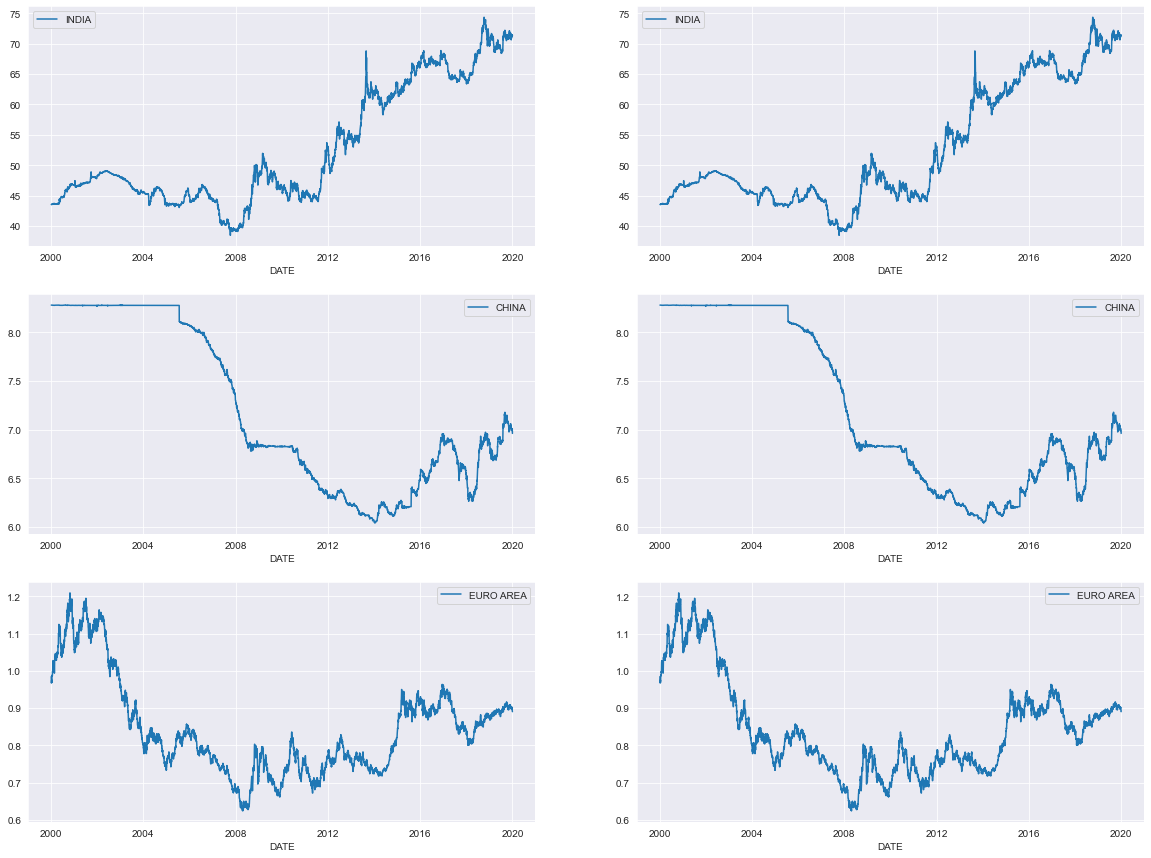

In [11]:
toInspect = ["INDIA", "CHINA", "EURO AREA"]
rows, cols = 3, 2
fig, ax = plt.subplots(rows, cols, figsize=(20,rows*5))

for row in range(rows):
    sns.lineplot(data=df[[toInspect[row]]], ax=ax[row][0])
    sns.lineplot(data=complete[[toInspect[row]]], ax=ax[row][1])

In [12]:
sampled2d = complete.resample("2D").mean()

In [13]:
# Data Conversion Utility

def getTimeSeriesData(A, window=7):
    X, y = list(), list()
    for i in range(len(A)):
        end_ix = i + window
        if end_ix > len(A) - 1:
            break
        seq_x, seq_y = A[i:end_ix], A[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [14]:
window = 2
num_features = 1

X, y = getTimeSeriesData(list(sampled2d["INDIA"]), window=window)
print("X:", X.shape)
print("Y:", y.shape)

# We need to add one more dimension to X, i.e Num of features in 1 sample of time step. as we are doing a univariate prediction which means number of features are 1 only
X = X.reshape((X.shape[0], X.shape[1], num_features))  # For LSTM
print("-----------")
print("X:", X.shape)
print("Y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("-----------")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

X: (3650, 2)
Y: (3650,)
-----------
X: (3650, 2, 1)
Y: (3650,)
-----------
X train: (2555, 2, 1)
y train: (2555,)
X test: (1095, 2, 1)
y test: (1095,)


In [20]:
# Define Model
model = Sequential()
model.add(LSTM(7, activation='relu', input_shape=(window, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=5, verbose=1)

Epoch 1/5
80/80 [==============================] - 1s 2ms/step - loss: 1227.9393
Epoch 2/5
80/80 [==============================] - 0s 2ms/step - loss: 27.5581
Epoch 3/5
80/80 [==============================] - 0s 2ms/step - loss: 0.1075
Epoch 4/5
80/80 [==============================] - 0s 2ms/step - loss: 0.0962
Epoch 5/5
80/80 [==============================] - 0s 2ms/step - loss: 0.0961


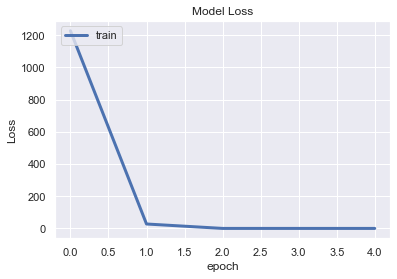

In [21]:
plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [22]:
yPred = model.predict(X_test, verbose=0)
yPred.shape = yPred.shape[0]

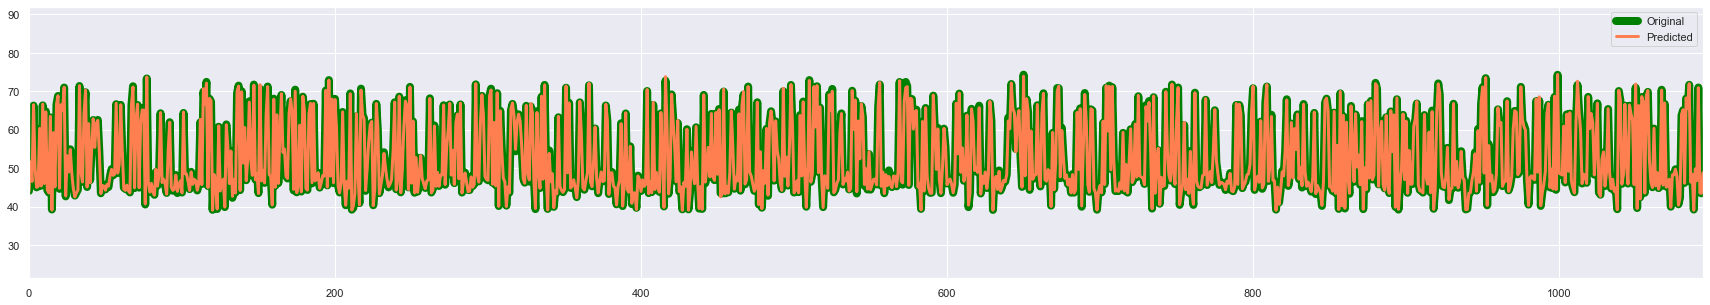

In [23]:
plt.figure(figsize=(30,5))
sns.set(rc={"lines.linewidth": 8})
sns.lineplot(x=np.arange(y_test.shape[0]), y=y_test, color="green")
sns.set(rc={"lines.linewidth": 3})
sns.lineplot(x=np.arange(y_test.shape[0]), y=yPred, color="coral")
plt.margins(x=0, y=0.5)
plt.legend(["Original", "Predicted"])

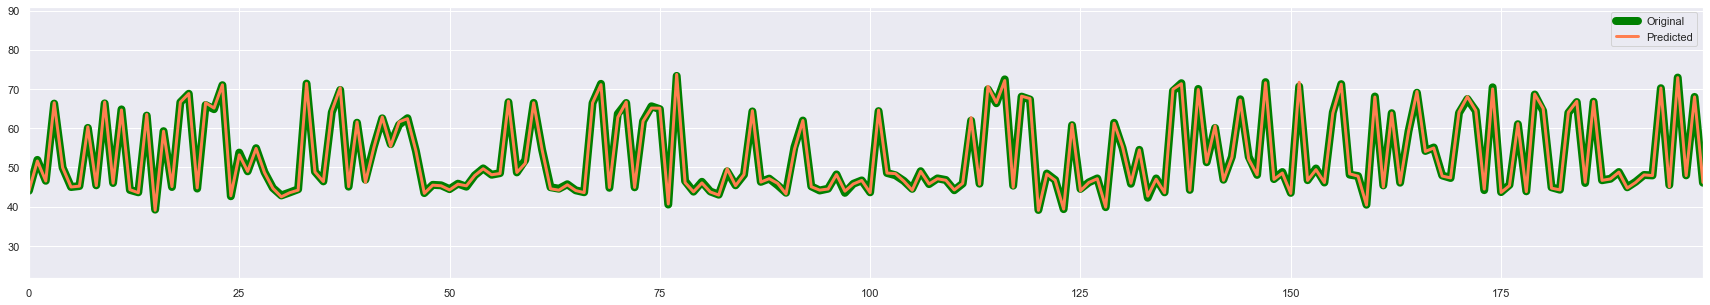

In [24]:
points = 200
plt.figure(figsize=(30,5))
sns.set(rc={"lines.linewidth": 8})
sns.lineplot(x=np.arange(points), y=y_test[:points], color="green")
sns.set(rc={"lines.linewidth": 3})
sns.lineplot(x=np.arange(points), y=yPred[:points], color="coral")
plt.margins(x=0, y=0.5)
plt.legend(["Original", "Predicted"])